# Experimenting with new location

- this playbook contains the code for the experimentation with new location

In [1]:
import os
import csv
import pandas as pd

version = "v5"
dataset_path = f"../data/processed/"

# files
filename = f"{version}-2_stages-full_statistical_with_window.csv"
filename2 = f"{version}-2_stages-fourier_window_big.csv"
filename3 = f"{version}-2_stages-fourier_normalized_int_XYZ.csv"
filename3 = f"{version}-2_stages-fourier_standardized_int_XYZ.csv"


# datasets
df_statistical = pd.read_csv(f"{dataset_path}/{filename}")
df_spectral = pd.read_csv(f"{dataset_path}/{filename2}")
df_spectral_normalized = pd.read_csv(f"{dataset_path}/{filename3}")
df_spectral_standardized = pd.read_csv(f"{dataset_path}/{filename3}")

In [2]:
from lib import device_mapping, reverse_device_mapping

# ------------------------------------------------
# choice of dataset

# df = df_statistical
# df = df_spectral
# df = df_spectral_normalized
df = df_spectral_standardized

# ------------------------------------------------
# choice of phone

# GooglePixel6:        03575768cc23b2df
# RedmiNote8PRO:       4aaf95a621ccf092
# SamsungGalaxyA51:    029a77f196804217
# SamsungGalaxyS6:     e08d976ac75c011e


# df = df[df['device_id'].isin(reverse_device_mapping(['RedmiNote8PRO']))]
# df = df[df['device_id'].isin(reverse_device_mapping(['GooglePixel6', 'RedmiNote8PRO']))]
df = df[df['device_id'].isin(reverse_device_mapping(['SamsungGalaxyA51', 'SamsungGalaxyS6']))]

# ------------------------------------------------
# choice of locations to include TOOD

# number of cases per device
df['device_id'].value_counts()


029a77f196804217    12828
e08d976ac75c011e     5607
Name: device_id, dtype: int64

In [3]:
correlation = df.iloc[:, 6:].apply(lambda x: df['label'].corr(x, method="pearson")).abs().sort_values(ascending=False)
pd.set_option('display.max_rows', 100)
correlation

Z_1            0.398473
Z_2            0.339536
Y_1            0.330285
Z_41           0.282605
Z_40           0.246063
                 ...   
X_32           0.004119
X_11           0.002196
intensity_7    0.001965
X_45           0.000856
Z_4            0.000583
Length: 199, dtype: float64

In [4]:
# feature selection. First k or all greater then some correlation
selection = correlation[:10].index
# selection = correlation[correlation > 0.05].index
df[selection]

,Z_1,Z_2,Y_1,Z_41,Z_40,Z_36,Y_41,Z_10,Y_9,intensity_44
0,5.638308,2.877935,7.367321,0.136108,0.129980,0.131908,0.086986,0.651797,0.392115,0.116064
1,4.990691,3.141740,6.597929,0.120129,0.118837,0.121782,0.083728,0.655494,0.350552,0.109312
2,4.533820,3.207650,5.798009,0.137018,0.128450,0.129934,0.084548,0.615390,0.388394,0.129304
3,3.968126,3.115833,4.953773,0.121788,0.114018,0.125030,0.084919,0.664883,0.354039,0.142256
4,3.375192,2.865751,4.064490,0.129110,0.120028,0.134233,0.082470,0.638579,0.389405,0.129002
...,...,...,...,...,...,...,...,...,...,...
26208,1.438913,0.831759,0.945452,0.151905,0.155286,0.216126,0.126357,0.573292,0.772786,0.167535
26209,1.433340,0.839757,0.945178,0.152489,0.154927,0.216591,0.127684,0.578119,0.784110,0.174113
26210,1.423364,0.887376,0.977083,0.153551,0.153445,0.213201,0.134462,0.556975,0.780099,0.180599
26211,1.423977,0.879475,0.979360,0.152873,0.152302,0.215088,0.132197,0.552465,0.772237,0.179722


In [5]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from lib import device_mapping

results = []
for location in list(df['location'].unique()):

    # test is one location, train the rest
    test = df[df['location'] == location]
    train = df[df['location'] != location]

    y_test = test['label'].to_numpy()
    X_test = test[selection].to_numpy()
    y_train = train['label'].to_numpy()
    X_train = train[selection].to_numpy()

    # SVM
    clf = svm.SVC(decision_function_shape='ovo')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_svm = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)

    # RF
    clf = RandomForestClassifier(max_depth=3)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_rf = sum([1 for i in range(len(y_pred)) if y_pred[i] == y_test[i]])/len(y_pred)

    device_name = device_mapping[test['device_id'].iloc[0]]
    results_temp = [location, device_name, acc_svm, acc_rf]
    results.append(results_temp)
    print(results_temp)

results_all = pd.DataFrame(results, columns=['Location', 'Device', 'SVM', 'RF', ])
results_all

['Restaurant', 'SamsungGalaxyA51', 0.8349775784753363, 0.9133034379671151]
['DormRoom5', 'SamsungGalaxyA51', 0.9459701492537314, 0.6349253731343284]
['DormRoom1', 'SamsungGalaxyA51', 0.8115292712066906, 0.777479091995221]
['DormRoom6', 'SamsungGalaxyA51', 0.9816876122082585, 0.8750448833034111]
['Kitchen2', 'SamsungGalaxyS6', 0.9523809523809523, 0.8169934640522876]
['DormRoom3', 'SamsungGalaxyS6', 0.866750208855472, 0.720969089390142]


,Location,Device,SVM,RF
0,Restaurant,SamsungGalaxyA51,0.834978,0.913303
1,DormRoom5,SamsungGalaxyA51,0.945970,0.634925
2,DormRoom1,SamsungGalaxyA51,0.811529,0.777479
3,DormRoom6,SamsungGalaxyA51,0.981688,0.875045
4,Kitchen2,SamsungGalaxyS6,0.952381,0.816993
5,DormRoom3,SamsungGalaxyS6,0.866750,0.720969


In [6]:
results_all[['SVM', 'RF']].mean()

SVM    0.898883
RF     0.789786
dtype: float64

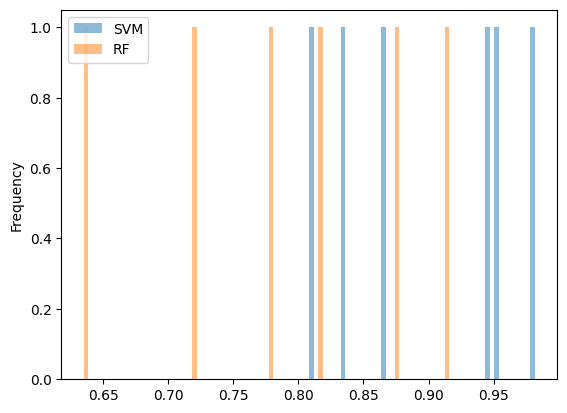

In [7]:
ax = results_all.plot.hist(bins=100, alpha=0.5)